___
<h1><center> Problema de clustering</center></h1>

___

## Segmentación de clientes de un distribuidor de venta al por mayor

### Descripción del problema:

El objetivo del problema es separar los clientes de un distribuidor al por mayor en grupos lo más homogéneos posibles pero que se diferencien entre ellos lo máximo posible de cara a realizar acciones dirigidas distintas para cada uno de los grupos. 

Haremos uso del dataset *Wholesale customers*. Este dataset se puede descargar de la siguiente ruta de la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Descárgate el fichero Wholesale_customers_data.csv del campus

<img src='wholesale.jpg' width=400px ></img>

### Descripción del dataset:

El dataset cuenta con **8 variables descriptivas X**.

El número total de muestras es de 440 clientes.

**Variables independientes X:**


1. FRESH: gasto anual (u.m.) en productos frescos (Continuo);
1. MILK: gasto anual (u.m.) en productos lácteos (Continuo);
1. GROCERY: gasto anual (u.m.) en productos comestibles (Continuo);
1. FROZEN: gasto anual (u.m.) en productos congelados (Continuo)
1. DETERGENTS_PAPER: gasto anual (u.m.) en detergentes y productos de papel (Continuo)
1. DELICATESSEN: gasto anual (u.m.) en productos delicatessen (Continuo);
1. CHANNEL: Canal de clientes - Horeca (Hotel / Restaurante / Café) o Canal minorista (Nominal)
1. REGION: Región de clientes - Lisnon, Oporto u Otros (Nominal)

**Más detalles de los datos:**

Existen dos variables categóricas o nominales, "REGION" y "CHANNEL".

REGION Frequency
* Lisbon 77
* Oporto 47
* Other Region 316

CHANNEL Frequency
* Horeca 298
* Retail 142

# Carga de librerías:

In [2]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1301/537660037.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Definición de funciones: 

In [3]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    fig_tot = (len(df.columns))
    fig_por_fila = int(3.)
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

# Lectura de datos:

In [4]:
os.listdir()

['problema_clustering_segmentacion_clientes_solucion.ipynb',
 '.ipynb_checkpoints',
 'wholesale.jpg',
 'wholesale_customers_data.csv']

In [5]:
X = pd.read_csv('wholesale_customers_data.csv')
print('- El número de filas en el dataset es: {}'.format(X.shape[0]))
print('- El número de columnas en el dataset es: {}'.format(X.shape[1]))
print('- Nombres de las variables: {}'.format(list(X.columns)))
X[:2]

- El número de filas en el dataset es: 440
- El número de columnas en el dataset es: 8
- Nombres de las variables: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


### Primero pasamos el canal y la región a valores entendibles: 

Usando la información de la descripción podemos saber qué valor corresponde con qué descripción. 

In [6]:
X['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [7]:
X['Region'].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [8]:
# Mapeo los datos
X['Channel'] = X['Channel'].map({1:'Horeca', 2:'Retail'})
X['Region'] = X['Region'].map({3:'Other Region', 2:'Oporto', 1: 'Lisboa'})

In [9]:
X[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776


# Preprocesamiento de datos

## Missings: 

In [10]:
X.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

# Visualizaciones y correlaciones

## Descriptivos básicos:

In [11]:
X.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Guardo en una variable **X_cuants** sólo las variables numéricas, ya que voy a representarlas y aplicar alguna transformación sobre ellas.

In [12]:
X_cuants = X[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].copy()

## Boxplots: 

In [13]:
X_normalizado = (X_cuants-X_cuants.mean())/X_cuants.std()

In [14]:
X_normalizado[:2]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050


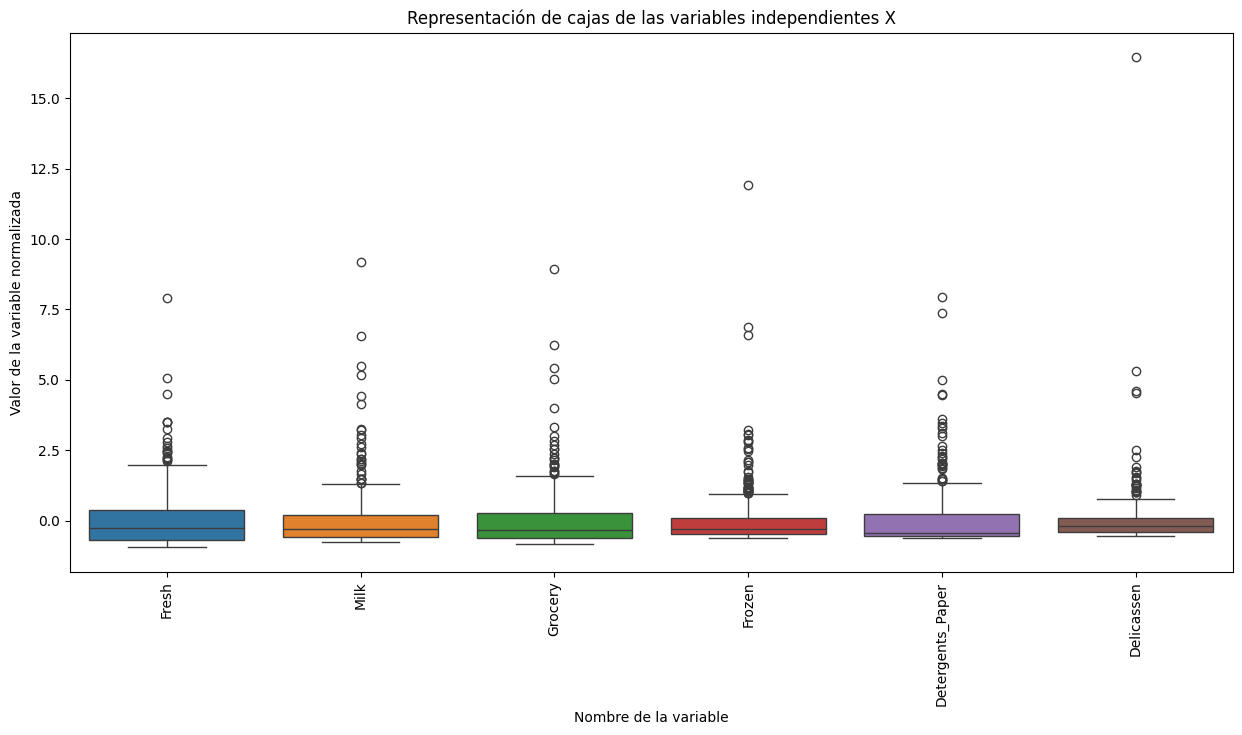

In [15]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Por lo que vemos en las representaciones de cajas todas las variables tienen algún outlier.

## Histogramas: 

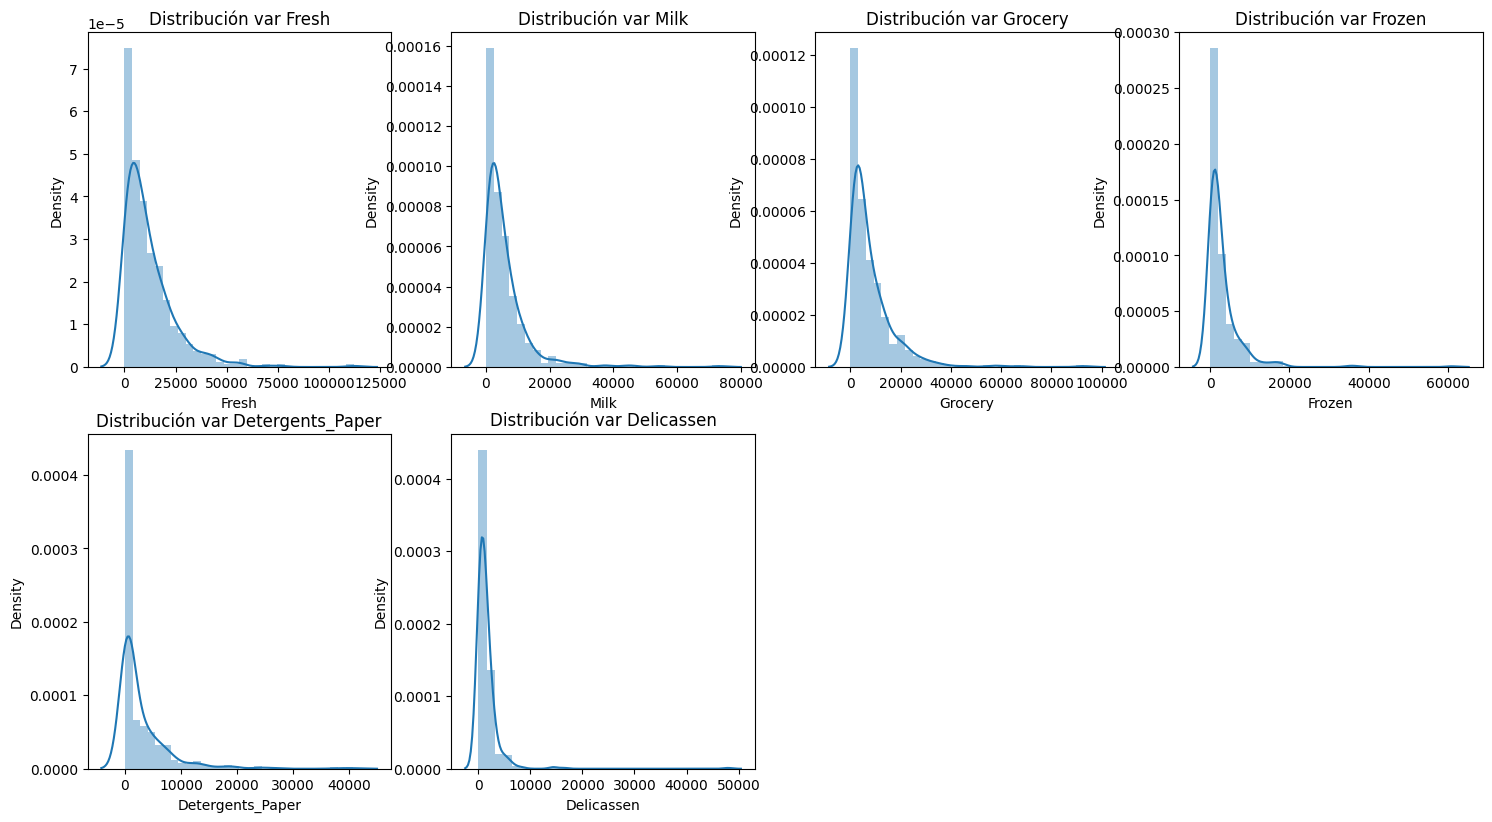

In [16]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

Las variables no siguen distribuciones normales o Gaussianas, como vemos en los histogramas. 

## Matriz de correlaciones: 

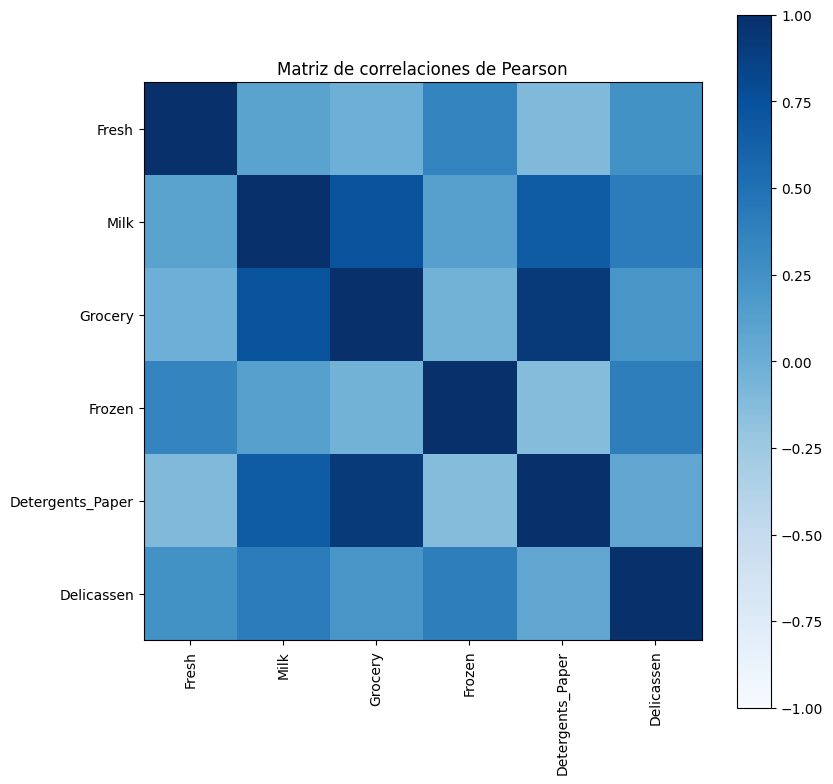

In [17]:
matriz_correlaciones = X_cuants.corr(method='pearson')
n_ticks = len(X_cuants.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X_cuants.columns, rotation='vertical')
plt.yticks(range(n_ticks), X_cuants.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

# Transformación de datos para cumplir las hipótesis: 

## Normalización de los datos: 

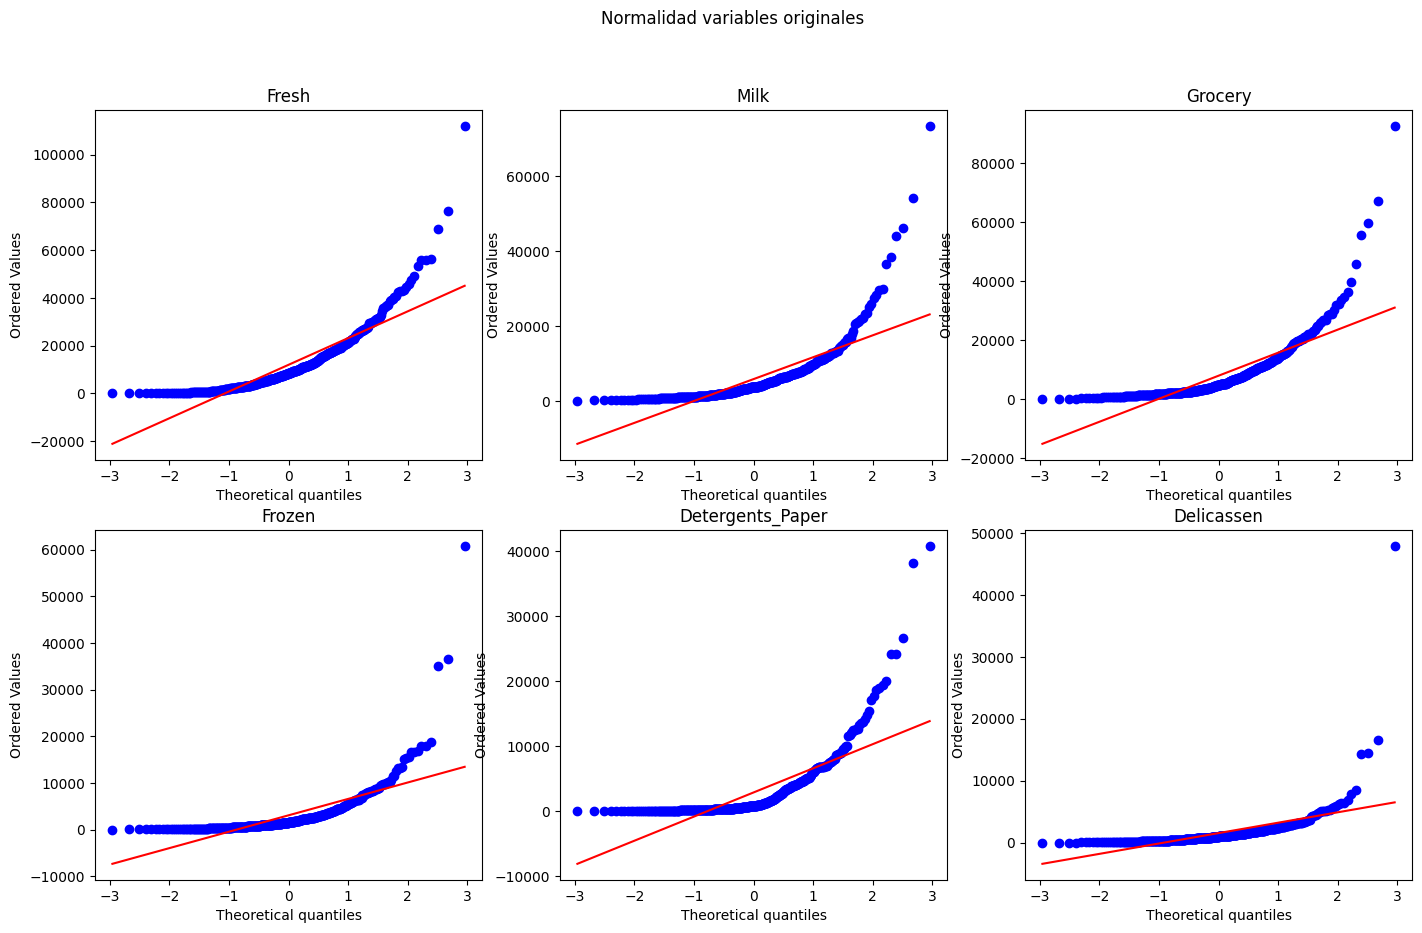

In [18]:
shapiro_test = comprueba_normalidad(X_cuants, title='Normalidad variables originales')

In [19]:
shapiro_test

,Test Statistic,p-value
Fresh,0.781436,7.918344e-24
Milk,0.628334,9.762267e-30
Grocery,0.676230,3.906112e-28
Frozen,0.528297,1.291356e-32
Detergents_Paper,0.605482,1.914582e-30
Delicassen,0.361068,1.753416e-36


In [20]:
bc = PowerTransformer(method='box-cox')
X_cuants_boxcox = bc.fit_transform(X_cuants)
X_cuants_boxcox = pd.DataFrame(X_cuants_boxcox, columns=X_cuants.columns)

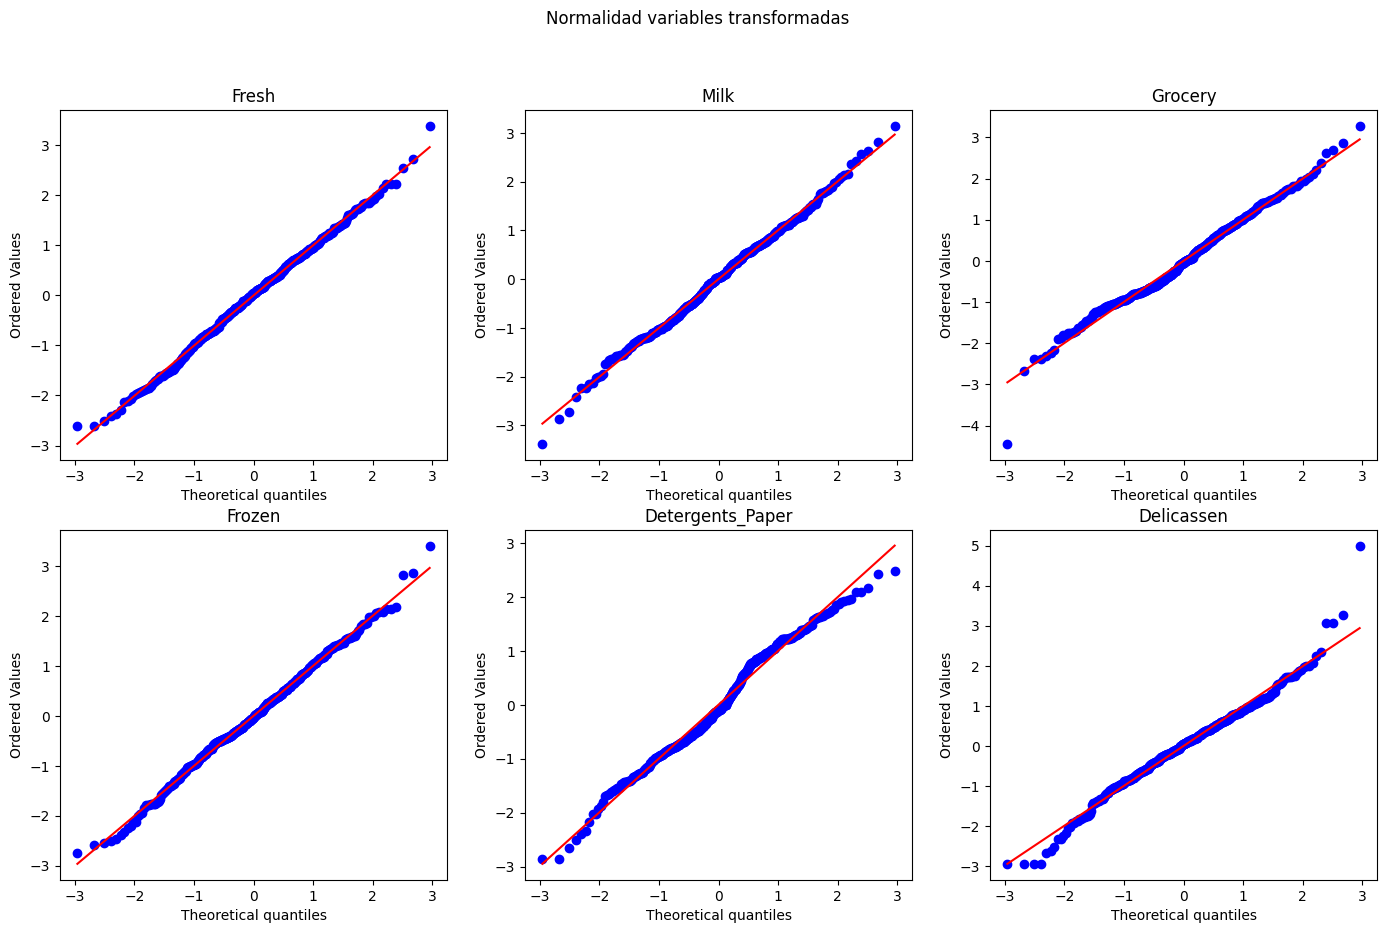

In [21]:
shapiro_test = comprueba_normalidad(X_cuants_boxcox, title='Normalidad variables transformadas')

In [22]:
shapiro_test

,Test Statistic,p-value
Fresh,0.997445,0.737783
Milk,0.996950,0.584384
Grocery,0.989160,0.002422
Frozen,0.997237,0.673645
Detergents_Paper,0.985208,0.000185
Delicassen,0.981868,0.000026


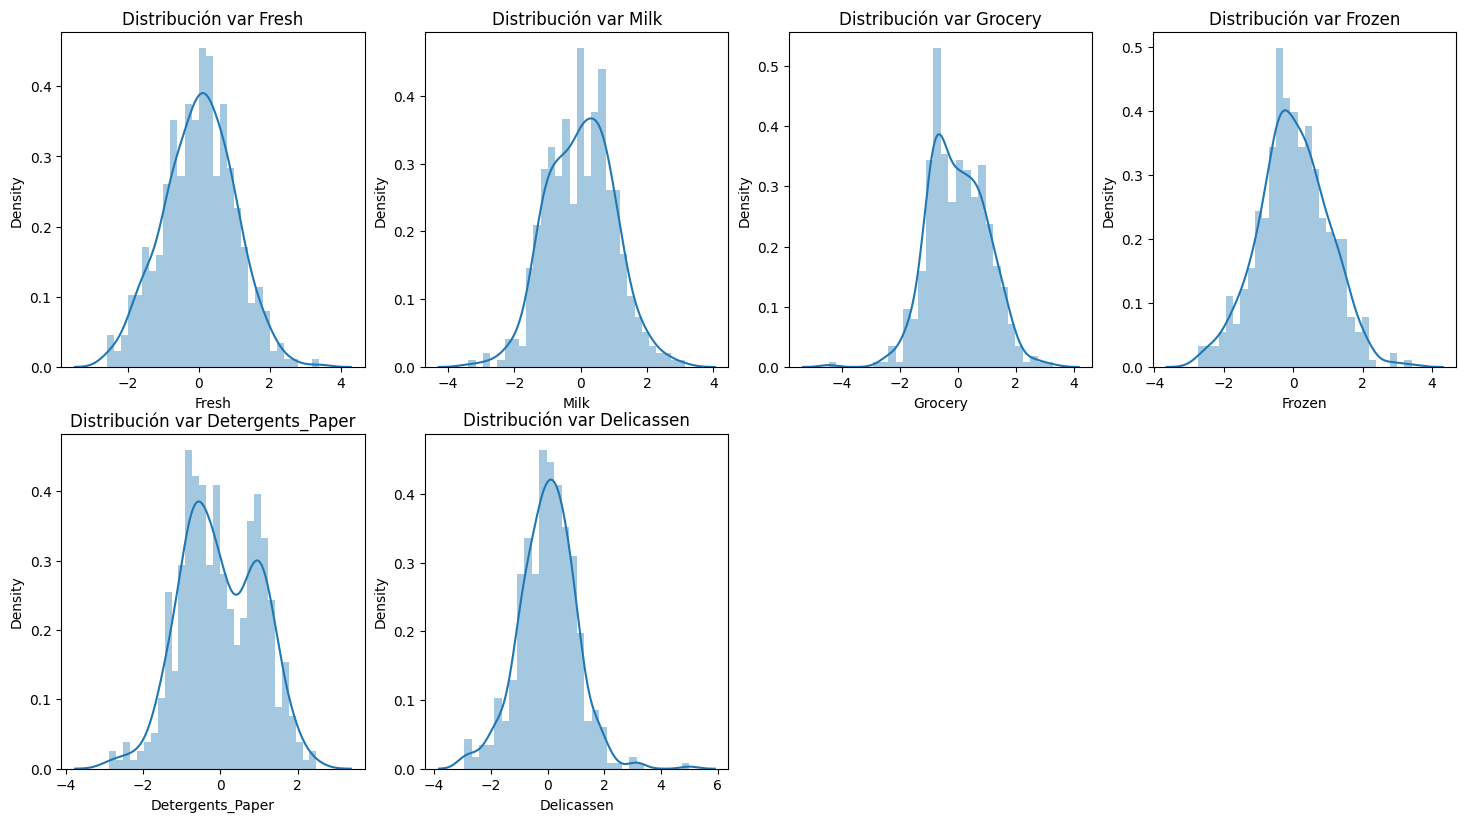

In [23]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants_boxcox.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants_boxcox[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Tratamiento de outliers:

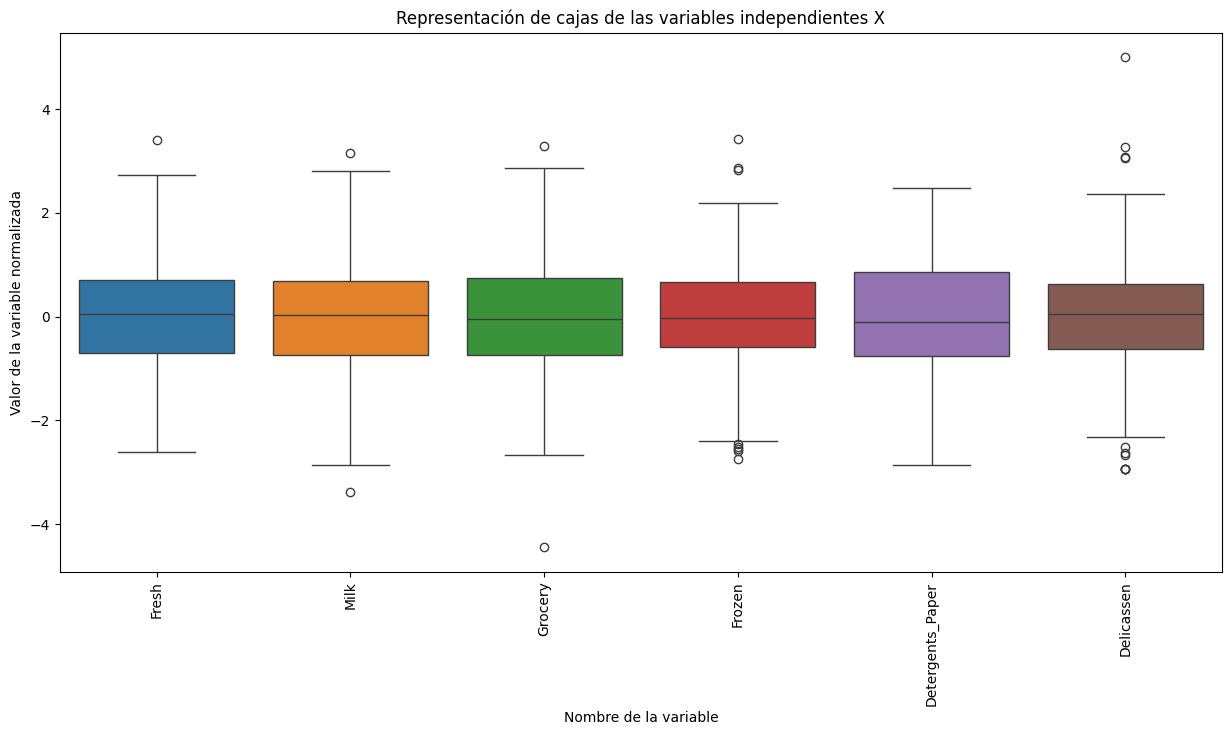

In [24]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

In [25]:
for k in list(X_cuants_boxcox.columns):
    IQR = np.percentile(X_cuants_boxcox[k],75) - np.percentile(X_cuants_boxcox[k],25)
    
    limite_superior = np.percentile(X_cuants_boxcox[k],75) + 1.5*IQR
    limite_inferior = np.percentile(X_cuants_boxcox[k],25) - 1.5*IQR
    
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] > limite_superior,limite_superior,X_cuants_boxcox[k])
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] < limite_inferior,limite_inferior,X_cuants_boxcox[k])

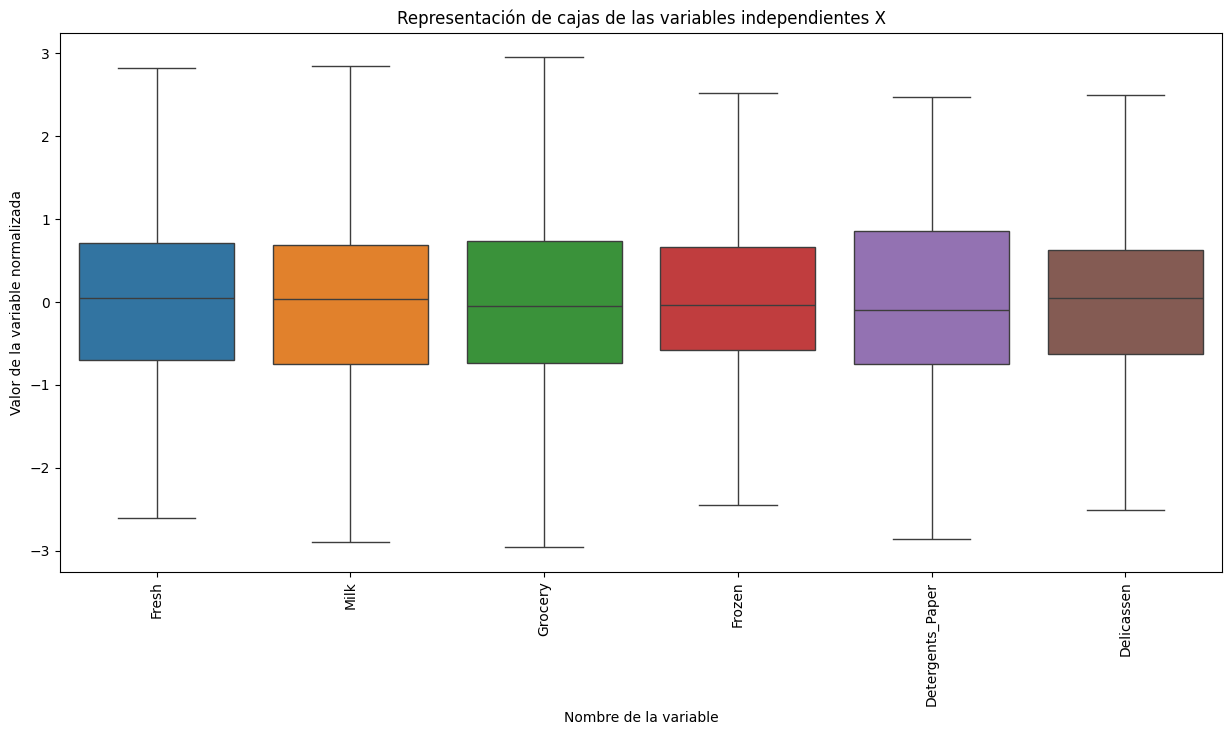

In [26]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

## Creo dummies de las variables categóricas

In [27]:
df  =  pd.concat([X[['Channel','Region']], X_cuants_boxcox], axis=1)
df[:3]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,Retail,Other Region,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,Retail,Other Region,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295


In [28]:
df = pd.get_dummies(df,columns=['Channel','Region'], drop_first=True)
df[:3]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779,True,False,True
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877,True,False,True
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295,True,False,True


## Escalado previo de los datos: 

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_escalado = scaler.fit_transform(df)
X_escalado = pd.DataFrame(X_escalado, columns=df.columns)
X_escalado.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.555805,0.675704,0.566972,0.199988,0.651772,0.567532,1.0,0.0,1.0
1,0.459410,0.678453,0.606514,0.508654,0.676366,0.620280,1.0,0.0,1.0
2,0.443793,0.659790,0.569644,0.559337,0.684170,0.948915,1.0,0.0,1.0
3,0.564108,0.337200,0.474040,0.728423,0.466264,0.621569,0.0,0.0,1.0
4,0.669174,0.577020,0.558857,0.641610,0.604411,0.847771,1.0,0.0,1.0


# Segmentación utilizando un clustering K-means:

In [30]:
cluster_range = range(1,20)
cluster_wss=[] 
for cluster in cluster_range:
    model = KMeans(cluster)
    model.fit(X_escalado)
    cluster_wss.append(model.inertia_)

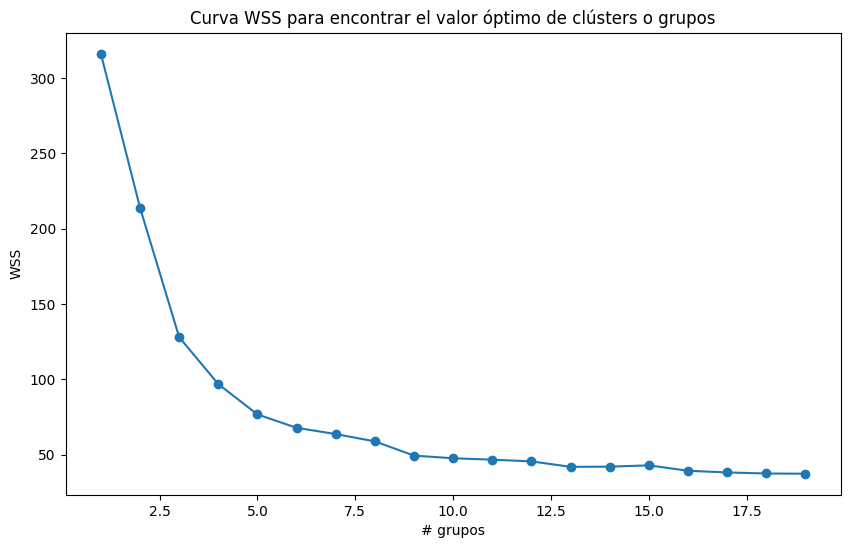

In [31]:
plt.figure(figsize=[10,6])
plt.title('Curva WSS para encontrar el valor óptimo de clústers o grupos')
plt.xlabel('# grupos')
plt.ylabel('WSS')
plt.plot(list(cluster_range),cluster_wss,marker='o')
plt.show()

#### Ajusto el modelo 

Ajusto el modelo con k=6 a los datos:

In [32]:
model = KMeans(n_clusters=6, random_state=0)
model.fit(X_escalado)

KMeans(n_clusters=6, random_state=0)

#### Predigo y obtengo clientes con su predicción 

In [33]:
df_total = X.copy()
df_total['cluster']= model.predict(X_escalado)
df_total[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,2
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,2


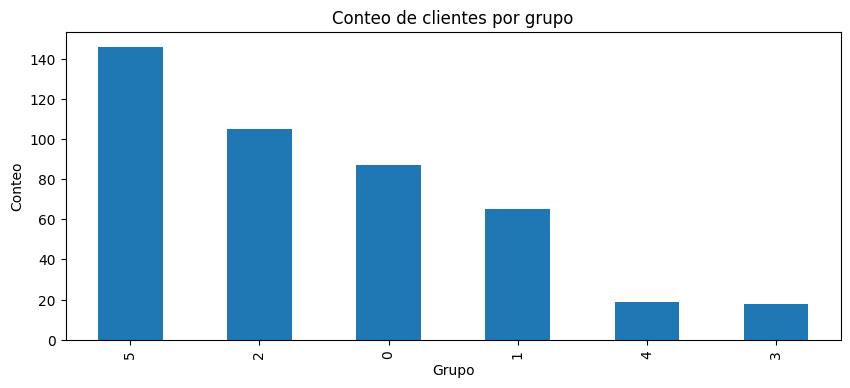

In [34]:
df_total.cluster.value_counts().plot(kind='bar', figsize=(10, 4))
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
_ = plt.ylabel('Conteo')

In [36]:
descriptivos_grupos = df_total.groupby(['cluster'], as_index=False)[df_total.select_dtypes(include=['number']).columns].mean()

descriptivos_grupos

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12499.402299,3366.218391,4145.011494,3969.804598,799.965517,1167.781609,0.0
1,25065.769231,5825.092308,5500.107692,7517.276923,913.538462,3396.815385,1.0
2,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524,2.0
3,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444,3.0
4,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000,4.0
5,8897.219178,2446.041096,3168.452055,1938.239726,730.205479,681.952055,5.0


# Obtenemos una representación de los grupos con PCA:

In [37]:
pca2 = PCA(n_components=2)
pc = pca2.fit_transform(X_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','cluster']
pca[:2]

,pc1,pc2,cluster
0,0.736695,0.260786,2
1,0.731883,0.249084,2


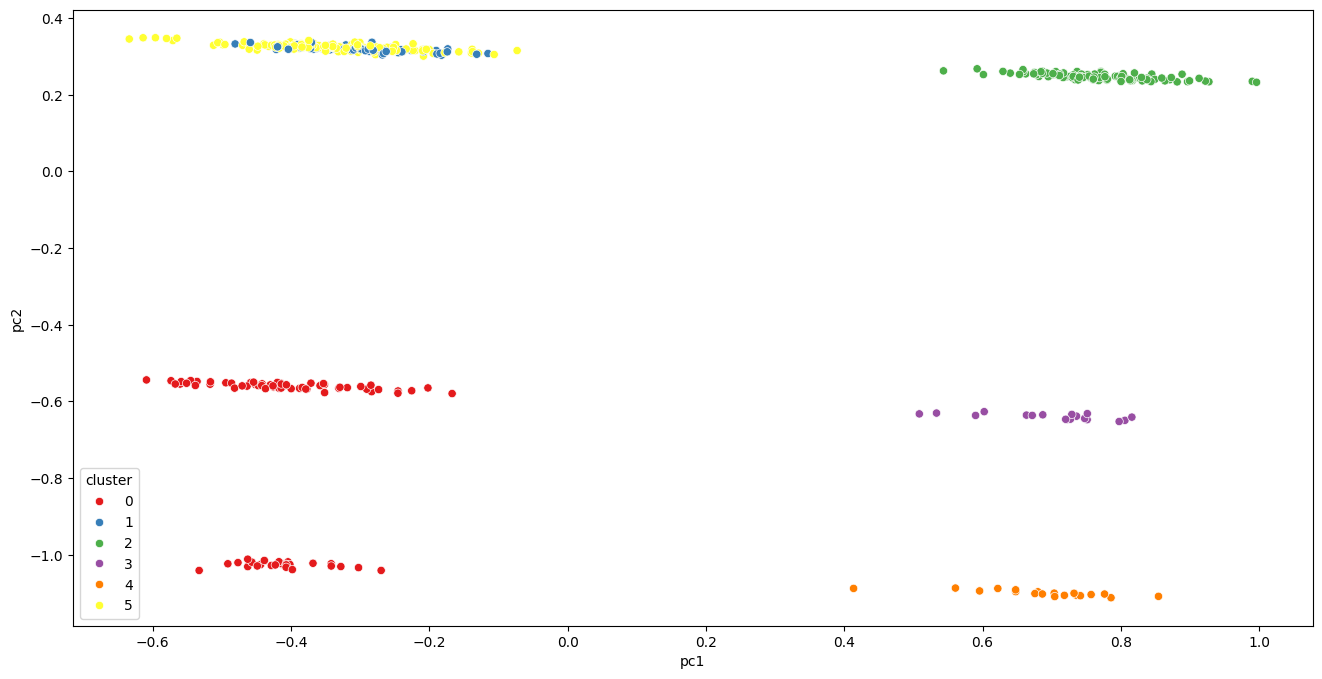

In [38]:
plt.figure(figsize=[16,8])
sns.scatterplot(x='pc1', y='pc2', hue= 'cluster', data=pca, palette='Set1')
plt.show()

# Explico los grupos usando las medias de cada variable por grupo:

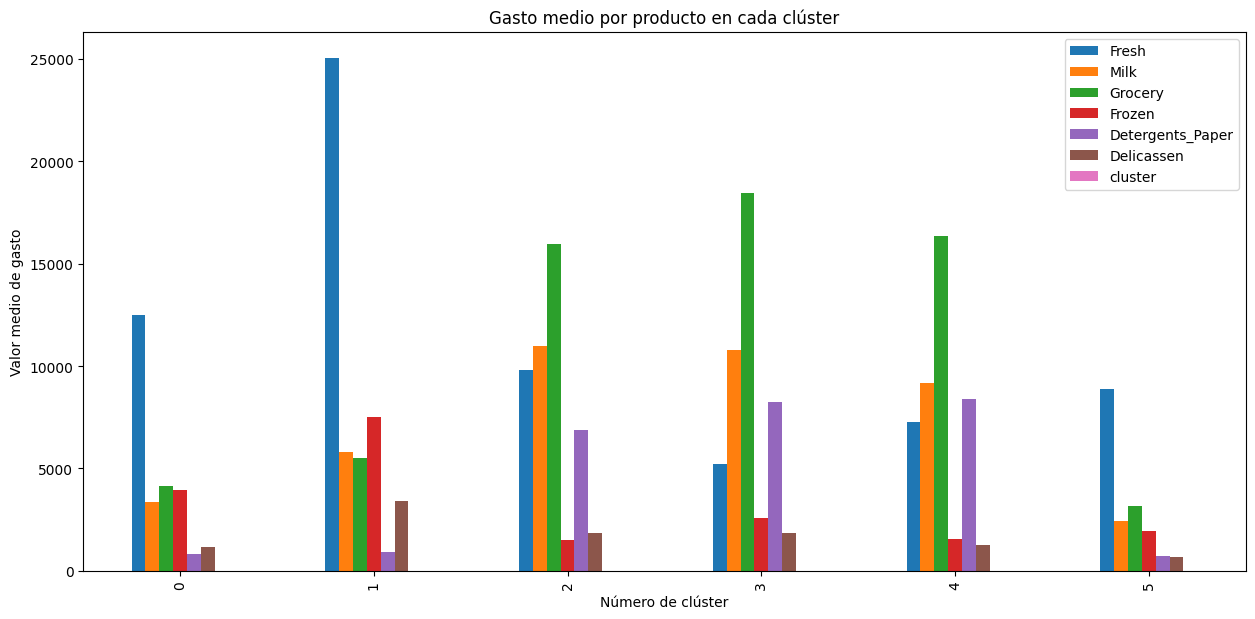

In [40]:
df_total.groupby('cluster')[df_total.select_dtypes(include=['number']).columns].mean().plot(kind='bar', figsize=(15,7))
plt.title('Gasto medio por producto en cada clúster')
plt.xlabel('Número de clúster')
_ = plt.ylabel('Valor medio de gasto')

In [41]:
df_total[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,2
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,2
